### Imports

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf  # 导入TensorFlow库，用于构建和训练机器学习模型
import shap # 导入SHAP库，用于解释模型预测
import seaborn as sns
import matplotlib.font_manager as fm
import csv
import os
import chardet

from multiprocessing.spawn import import_main_path
from sklearn.preprocessing import MinMaxScaler
shap.initjs()   # 初始化SHAP的JavaScript环境
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape  # 导入Input和Dense，用于构建网络层
from tensorflow.keras import regularizers  # 导入regularizers，用于添加正则化
from tensorflow.keras.callbacks import EarlyStopping  # 导入EarlyStopping，用于提前停止训练
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.losses import MeanSquaredError  
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
# mpl.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
# plt.rcParams['axes.unicode_minus'] = False # 设置坐标轴负号
# plt.rcParams['font.size'] = 23  # 设置字体大小
# plt.rcParams['figure.dpi'] = 3000  # 设置图像分辨率

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
 
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

### 数据预处理

In [89]:
# 加载 CSV 文件
data = pd.read_csv("../data/water/整理好的csv/杭州202101-202112/东苕溪202101-202112.csv", encoding="gb2312").dropna()  # 读取CSV文件并删除缺失值
# 'gb2312', 'gbk', 'gb18030', 'utf-8'
# data['Timestamp'] = pd.to_datetime(data['监测时间'], format = '%Y-%m-%d %H:%M')
# data.drop(['省份','城市','河流','流域'],axis = 1,inplace= True)  # 删除不需要的列
data.drop(['省份','城市','河流','流域','断面名称','监测时间','水质类别'],axis = 1,inplace= True)  # 删除不需要的列
# data = data.reset_index(drop=True) # 重置索引
# data = data[]
# data = data.T
# data = data.iloc[3:]
# 将非数值数据转换为 NaN
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 处理缺失值
data.fillna(0, inplace=True)  # 用 0 填充缺失值，或者你可以选择其他合适的值

# 显示数据类型
print(data.dtypes)


水温      float64
pH      float64
溶解氧     float64
高锰酸钾    float64
氨氮      float64
总磷      float64
总氮      float64
电导率     float64
浊度      float64
dtype: object


In [90]:
# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 删除重复行
data.drop_duplicates(inplace=True)

# 显示前10行数据
print(data.head())

# 查看数据的基本信息
data.info()
# data.head()

    水温    pH    溶解氧  高锰酸钾     氨氮     总磷    总氮    电导率    浊度
0  8.4  8.08  10.91  1.82  0.102  0.051  1.87  415.8  20.7
1  8.0  8.04  10.73  1.74  0.109  0.050  1.69  418.2  18.2
2  7.8  8.02  10.59  1.65  0.119  0.048  2.40  418.6  15.9
3  8.3  8.05  10.90  1.74  0.117  0.044  2.10  418.8  13.9
4  8.9  8.07  11.00  1.59  0.121  0.046  2.05  418.8  13.2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   水温      2562 non-null   float64
 1   pH      2562 non-null   float64
 2   溶解氧     2562 non-null   float64
 3   高锰酸钾    2562 non-null   float64
 4   氨氮      2562 non-null   float64
 5   总磷      2562 non-null   float64
 6   总氮      2562 non-null   float64
 7   电导率     2562 non-null   float64
 8   浊度      2562 non-null   float64
dtypes: float64(9)
memory usage: 180.3 KB


C:\Users\admin\AppData\Local\Temp\ipykernel_2568\341957695.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [91]:
# # 将日期转换为日期时间格式
# data['监测时间'] = pd.to_datetime(data['监测时间'], format='%Y/%m/%d %H:%M')
# # data = data[data['hour'].between(0, 23)]  # 确保小时在0到23之间

# 统计每列中空值的数量
data.isnull().sum()

水温      0
pH      0
溶解氧     0
高锰酸钾    0
氨氮      0
总磷      0
总氮      0
电导率     0
浊度      0
dtype: int64

In [92]:
# 查找系统中的中文字体
zh_fonts = [f.name for f in fm.fontManager.ttflist if 'CN' in f.name or 'Kai' in f.name or 'Hei' in f.name]

# 如果找到了可用的中文字体，使用第一个找到的
if zh_fonts:
    plt.rcParams['font.sans-serif'] = [zh_fonts[1]]  # 自动选择系统中的可用中文字体
else:
    print("未找到中文字体，确保系统中安装了中文字体。")

plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

In [93]:
# 特征标准化
data_norm = (data - data.mean()) / data.std()  # 标准化数据
# data_norm = data_norm.iloc[:, 1:]
data_norm = data_norm.astype('float32')  # 转换数据类型
start_sclice=540  # 定义切片起始位置
# 构建自编码器模型
data_norm_train = pd.concat([data_norm[:start_sclice],data_norm[start_sclice+300:]],ignore_index=True) # 训练数据
data_norm_test = data_norm[start_sclice:start_sclice+300]  # 测试数据
# data_norm_train,data_norm_test = train_test_split(data_norm,test_size=0.2)

### AE

#### AE-ALL

In [117]:
input_dim = data_norm.shape[1]  # 输入维度
encoding_dim = 5  # 编码维度
# 构建编码器和解码器
input_layer = tf.keras.layers.Input(shape=(input_dim,)) # 创建输入层，接收形状为 (input_dim,) 的输入数据
# 创建第一个全连接层作为编码器的一部分，使用 8 个神经元，ReLU 激活函数，并添加 L1 正则化项（权重衰减）来防止过拟合
encoder = Dense(8, activation="relu",
                activity_regularizer=regularizers.l1(10e-7))(input_layer)

encoder = Dense(5, activation="relu",
                kernel_regularizer=regularizers.l2(10e-7))(encoder)

encoder = Dense(3, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(encoder)
# 创建第一个全连接层作为解码器的一部分，使用 5 个神经元，ReLU 激活函数，并添加 L2 正则化项来防止过拟合
decoder = Dense(5, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(decoder)
# 创建输出层，使用与输入层相同数量的神经元，Sigmoid 激活函数，并添加 L2 正则化项来防止过拟合
# Sigmoid 激活函数用于将输出值限制在 0 和 1 之间，适用于将输出值解释为概率
decoder = Dense(input_dim, activation='sigmoid',
                kernel_regularizer=regularizers.l2(10e-7))(decoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)  # 构建模型
autoencoder.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # 编译模型
# 训练自编码器模型
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # 定义提前停止的参数
history = autoencoder.fit(data_norm_train,data_norm_train, epochs=50, batch_size=11, shuffle=True, validation_data=(data_norm_train, data_norm_train), callbacks=[earlystopper])
# 使用自编码器模型对数据进行预测
reconstructed_data = autoencoder.predict(data_norm_test)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.9798 - mse: 0.9798 - val_loss: 1.1680 - val_mse: 1.1680
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9571 - mse: 0.9570 - val_loss: 1.1197 - val_mse: 1.1196
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6994 - mse: 0.6994 - val_loss: 1.1122 - val_mse: 1.1121
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2261 - mse: 1.2261 - val_loss: 1.1059 - val_mse: 1.1058
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5925 - mse: 1.5925 - val_loss: 1.1008 - val_mse: 1.1008
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8106 - mse: 1.8105 - val_loss: 1.0961 - val_mse: 1.0960
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8176 - mse: 0.8176 - val_loss: 1.0919 - val_mse: 1.0918
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4379 - mse: 0.4378 - val_loss: 1.0882 - val_mse: 1.0881
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

#### AE-1（水温）

In [127]:
# # 提取'水温'数据  
# temp_data = data_norm.iloc[:, 0]  # 假设'水温'是第一个参数，使用iloc来访问第一列的所有行  
  
# # 转换为适合模型输入的格式  
# temp_data = temp_data.values.reshape(-1, 1)  # 假设temp_data已经是归一化后的数据  
# temp_data_train = data_norm_train.iloc[:, 0].values.reshape(-1, 1)
# temp_test_data = data_norm_test.iloc[:, 0].values.reshape(-1, 1)
temp_data_train = data_norm_train.loc[:, "水温"].values.reshape(-1, 1)
temp_test_data = data_norm_test.loc[:, "水温"].values.reshape(-1, 1)
# 加入噪声数据
noise_factor = 0.1
temp_data_train_noisy = temp_data_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=temp_data_train.shape)
temp_data_train_noisy = np.clip(temp_data_train_noisy, 0., 1.)  # 保持数据在0到1之间


# 编码器和解码器的定义（与上面类似，但仅针对一个参数）  
input_dim = 1  # '水温'的维度  
latent_dim = 2  # 潜在空间维度，可以根据需要调整  

# 构建编码器和解码器
# 可调整网络结构，改变网络层数以及神经元数量
input_layer = tf.keras.layers.Input(shape=(input_dim,)) # 创建输入层，接收形状为 (input_dim,) 的输入数据
# 创建第一个全连接层作为编码器的一部分，使用 8 个神经元，ReLU 激活函数，并添加 L1 正则化项（权重衰减）来防止过拟合
encoder = Dense(8, activation="relu",
                activity_regularizer=regularizers.l1(10e-8))(input_layer)
# 可调整正则化参数，参数设置过高会导致模型欠拟合，或者尝试只使用一种正则化
# 激活函数：ReLU、sigmoid、LeakyReLU、tanh 或 ELU
encoder = Dense(5, activation="relu",
                kernel_regularizer=regularizers.l2(10e-8))(encoder)

encoder = Dense(3, activation='relu',
                kernel_regularizer=regularizers.l2(10e-8))(encoder)

# 创建第一个全连接层作为解码器的一部分，使用 5 个神经元，ReLU 激活函数，并添加 L2 正则化项来防止过拟合
decoder = Dense(5, activation='relu',
                kernel_regularizer=regularizers.l2(10e-8))(encoder)
decoder = Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(10e-8))(decoder)
# 创建输出层，使用与输入层相同数量的神经元，Sigmoid 激活函数，并添加 L2 正则化项来防止过拟合
# Sigmoid 激活函数用于将输出值限制在 0 和 1 之间，适用于将输出值解释为概率
decoder = Dense(input_dim, activation='sigmoid',
                kernel_regularizer=regularizers.l2(10e-8))(decoder)

autoencoder1 = tf.keras.Model(inputs=input_layer, outputs=decoder)  # 构建模型
# autoencoder1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # 编译模型
autoencoder1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),    # 可调整学习率
                     loss='mean_squared_error', metrics=['mse'])
# 优化器：'adam' 'RMSprop' 或 'SGD'

# 训练自编码器模型
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # 定义提前停止的参数
# history = autoencoder1.fit(temp_data_train,temp_test_data, epochs=50, batch_size=20, shuffle=True, validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])
history = autoencoder1.fit(temp_data_train_noisy, temp_data_train, epochs=50, 
                           batch_size=10, shuffle=True,
                           validation_data=(temp_data_train, temp_data_train),
                           callbacks=[earlystopper])
# 使用自编码器模型对数据进行预测
reconstructed_data = autoencoder1.predict(temp_test_data)


# 异常检测  
def detect_anomalies(data, model, threshold=0.1):  
    reconstructed = model.predict(data)  
    mse = MeanSquaredError()(data, reconstructed)  
    anomalies = mse > threshold  
    return anomalies  
# def detect_anomalies(data, model, percentile=95):
#     reconstructed = model.predict(data)
#     mse = MeanSquaredError()(data, reconstructed).numpy()
#     threshold = np.percentile(mse, percentile)  # 动态选择阈值
#     anomalies = mse > threshold
#     return anomalies
# 使用模型检测异常  
anomalies = detect_anomalies(temp_data_train, autoencoder1, threshold=0.05)  # 阈值根据具体情况调整

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3729 - mse: 0.3729 - val_loss: 1.3696 - val_mse: 1.3696
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2652 - mse: 0.2652 - val_loss: 1.3371 - val_mse: 1.3371
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2687 - mse: 0.2687 - val_loss: 1.3054 - val_mse: 1.3054
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7919 - mse: 0.7919 - val_loss: 1.2754 - val_mse: 1.2754
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2331 - mse: 0.2331 - val_loss: 1.2454 - val_mse: 1.2454
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3970 - mse: 1.3970 - val_loss: 1.2209 - val_mse: 1.2209
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4947 - mse: 0.4947 - val_loss: 1.1999 - val_mse: 1.1999
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3742 - mse: 0.3742 - val_loss: 1.1834 - val_mse: 1.1834
Epoch 9/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

#### AE-2（pH）

In [128]:
# temp_data_train = data_norm_train.iloc[:, 1].values.reshape(-1, 1)
# temp_test_data = data_norm_test.iloc[:, 1].values.reshape(-1, 1)
temp_data_train = data_norm_train.loc[:, "pH"].values.reshape(-1, 1)
temp_test_data = data_norm_test.loc[:, "pH"].values.reshape(-1, 1)

# 加入噪声数据
noise_factor = 0.1
temp_data_train_noisy = temp_data_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=temp_data_train.shape)
temp_data_train_noisy = np.clip(temp_data_train_noisy, 0., 1.)  # 保持数据在0到1之间

input_dim = 1  # 'pH'的维度  
latent_dim = 2  # 潜在空间维度，可以根据需要调整  

# 构建编码器和解码器
input_layer = tf.keras.layers.Input(shape=(input_dim,)) # 创建输入层，接收形状为 (input_dim,) 的输入数据
encoder = Dense(8, activation="relu",
                activity_regularizer=regularizers.l1(10e-7))(input_layer)

encoder = Dense(5, activation="relu",
                kernel_regularizer=regularizers.l2(10e-7))(encoder)

encoder = Dense(3, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(5, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(decoder)
decoder = Dense(input_dim, activation='sigmoid',
                kernel_regularizer=regularizers.l2(10e-7))(decoder)

autoencoder2 = tf.keras.Model(inputs=input_layer, outputs=decoder)  # 构建模型
autoencoder2.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # 编译模型
# 训练自编码器模型
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # 定义提前停止的参数
history = autoencoder2.fit(temp_data_train,temp_data_train, epochs=50, batch_size=100, shuffle=True, validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])
# 使用自编码器模型对数据进行预测
reconstructed_data = autoencoder2.predict(temp_test_data)

# 异常检测  
def detect_anomalies2(data, model, threshold=0.1):  
    reconstructed = model.predict(data)  
    mse = MeanSquaredError()(data, reconstructed)  
    anomalies = mse > threshold  
    return anomalies  
  
# 使用模型检测异常  
anomalies = detect_anomalies2(temp_data_train, autoencoder2, threshold=0.05)  # 阈值根据具体情况调整

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.8242 - mse: 0.8241 - val_loss: 1.3688 - val_mse: 1.3688
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2466 - mse: 1.2465 - val_loss: 1.3160 - val_mse: 1.3159
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6577 - mse: 0.6577 - val_loss: 1.2418 - val_mse: 1.2418
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6558 - mse: 0.6557 - val_loss: 1.1774 - val_mse: 1.1773
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2857 - mse: 0.2857 - val_loss: 1.1485 - val_mse: 1.1484
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8222 - mse: 0.8222 - val_loss: 1.1397 - val_mse: 1.1396
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0203 - mse: 4.0202 - val_loss: 1.1366 - val_mse: 1.1365
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8263 - mse: 1.8262 - val_loss: 1.1352 - val_mse: 1.1351
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5782 - mse:

#### AE-3（溶解氧）

#### AE-4（高锰酸钾）

#### AE-5（氨氮）

#### AE-6（总磷）

#### AE-7（总氮）

#### AE-8（电导率）

#### AE-9（浊度）

### VAE

#### VAE-ALL

In [129]:
def kl_divergence(z_mean, z_log_var):  
    # 计算KL散度  
    # z_mean 和 z_log_var 是编码器的输出，分别代表潜在空间的均值和对数方差  
    # 我们假设先验分布为标准正态分布（均值为0，方差为1）  
      
    # 计算方差  
    z_var = tf.exp(z_log_var)  
      
    # 计算KL散度的每个分量  
    kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var, axis=-1)  
      
    # 返回KL散度的平均值（如果需要的话）  
    return tf.reduce_mean(kl_loss)  
  
  
input_dim = data_norm.shape[1]  # 输入维度  
latent_dim = 5  # 潜在空间维度  

# 编码器  
inputs = Input(shape=(input_dim,))  
x = Dense(128, activation='relu')(inputs)  
x = Dense(64, activation='relu')(x)  
z_mean = Dense(latent_dim, name='z_mean')(x)  
z_log_var = Dense(latent_dim, name='z_log_var')(x)  

# 重参数技巧（Reparameterization Trick）  
def sampling(args):  
    z_mean, z_log_var = args  
    batch = K.shape(z_mean)[0]  
    dim = K.shape(z_mean)[1]  
    epsilon = K.random_normal(shape=(batch, dim))  
    return z_mean + K.exp(0.5 * z_log_var) * epsilon  

# 使用重参数技巧从潜在空间采样  
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  
  
# 解码器  
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')  
x = Dense(64, activation='relu')(latent_inputs)  
x = Dense(128, activation='relu')(x)  
outputs = Dense(input_dim, activation='sigmoid')(x)  
  
# 实例化编码器和解码器模型  
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')  
decoder = Model(latent_inputs, outputs, name='decoder')  

# VAE模型，将编码器输出作为解码器的输入  
outputs = decoder(encoder(inputs)[2])  
vae = Model(inputs, outputs, name='vae') 

# VAE损失函数
def vae_loss(z_mean, z_log_var):  
    reconstruction_loss = MeanSquaredError()(z_mean, z_log_var)  # 直接使用 MeanSquaredError
    kl_loss = kl_divergence(z_mean, z_log_var) 
    return K.mean(reconstruction_loss + kl_loss)  

# 编译VAE模型，使用自定义损失函数  
vae.compile(optimizer='adam', loss=vae_loss) 
  
# 训练VAE  
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)  
history = vae.fit(data_norm_train, data_norm_train, epochs=50, batch_size=50, shuffle=True,  
                  validation_data=(data_norm_train, data_norm_train), callbacks=[earlystopper])  
  
# 使用VAE模型对数据进行预测  
reconstructed_data = vae.predict(data_norm_test)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.7173 - val_loss: 6.1907
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9771 - val_loss: 6.1836
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1987 - val_loss: 6.1832
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5959 - val_loss: 6.1830
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5538 - val_loss: 6.1828
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8166 - val_loss: 6.1823
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6328 - val_loss: 6.1788
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8079 - val_loss: 6.1688
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5057 - val_loss: 6.1670
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5308 - val_loss: 6.1665
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8106 - val_loss: 6.1663
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5226 - val_lo

#### VAE-1（水温）

In [124]:
temp_data_train = data_norm_train.iloc[:, 0].values.reshape(-1, 1)
temp_test_data = data_norm_test.iloc[:, 0].values.reshape(-1, 1)  
# 加入噪声数据
noise_factor = 0.1
temp_data_train_noisy = temp_data_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=temp_data_train.shape)
temp_data_train_noisy = np.clip(temp_data_train_noisy, 0., 1.)  # 保持数据在0到1之间

def kl_divergence1(z_mean, z_log_var):  
    # z_mean = K.cast(z_mean, 'float32')
    # z_log_var = K.cast(z_log_var, 'float32')
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    return K.mean(kl_loss)
    # return kl_loss  # 返回未经平均的 KL 损失

# 编码器和解码器的定义（与上面类似，但仅针对一个参数）  
input_dim = 1  # '水温'的维度  
# input_dim = data_norm.shape[1]  # 输入维度  
latent_dim = 2  # 潜在空间维度，可以根据需要调整  
  
# 编码器  
inputs = Input(shape=(input_dim,))  
x = Dense(128, activation='relu')(inputs)  
x = Dense(64, activation='relu')(x)  
z_mean1 = Dense(latent_dim, name='z_mean1')(x)  
z_log_var1 = Dense(latent_dim, name='z_log_var1')(x) 

# 重参数技巧（Reparameterization Trick）  
def sampling(args):  
    z_mean1, z_log_var1 = args  
    batch = K.shape(z_mean1)[0]  
    dim = K.shape(z_mean1)[1]  
    epsilon = K.random_normal(shape=(batch, dim))  
    return z_mean1 + K.exp(0.5 * z_log_var1) * epsilon  

# 使用重参数技巧从潜在空间采样  
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean1, z_log_var1])  
  
# 解码器  
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')  
x = Dense(64, activation='relu')(latent_inputs)  
x = Dense(128, activation='relu')(x)  
outputs = Dense(input_dim, activation='sigmoid')(x)  
  
# 实例化模型  
encoder = Model(inputs, [z_mean1, z_log_var1, z], name='encoder')  
decoder = Model(latent_inputs, outputs, name='decoder')  
outputs = decoder(encoder(inputs)[2])  
vae1 = Model(inputs, outputs, name='vae1') 


# # 编译模型时，自动添加 KL 散度损失
# # vae1.add_loss(kl_divergence1(z_mean1, z_log_var1))
# vae1.add_loss(kl_divergence1(encoder.get_layer('z_mean1').output, encoder.get_layer('z_log_var1').output))
# # vae1.add_loss(kl_divergence1(encoder.output[0], encoder.output[1]))
# vae1.compile(optimizer='adam', loss='mse', metrics=['mse'])
# # vae1.compile(optimizer='adam', loss=None)
# # vae1.compile(optimizer='adam', loss=vae_loss, metrics=['mse'])

# VAE损失函数
def vae_loss1(z_mean, z_log_var):  
    reconstruction_loss = MeanSquaredError()(z_mean, z_log_var)  # 直接使用 MeanSquaredError
    kl_loss = kl_divergence1(z_mean, z_log_var) 
    return K.mean(reconstruction_loss + kl_loss)  

# 编译VAE模型，使用自定义损失函数  
vae1.compile(optimizer='adam', loss=vae_loss1) 

# 训练VAE 
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)  
# history = vae1.fit(temp_data_train, temp_data_train, epochs=50, batch_size=11, shuffle=True,  
#                   validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])  
history = vae1.fit(temp_data_train_noisy, temp_data_train, epochs=50, batch_size=11, shuffle=True,  
                  validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])  


# 使用VAE模型对数据进行预测
reconstructed_data = vae1.predict(temp_test_data)  

# 异常检测  
def detect_anomalies(data, model, threshold=0.1):  
    reconstructed = model.predict(data)  
    mse = MeanSquaredError()(data, reconstructed)  
    anomalies = mse > threshold  
    return anomalies  
  
# 使用模型检测异常  
anomalies = detect_anomalies(temp_data_train, vae1, threshold=0.05)  # 阈值根据具体情况调整

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.4149 - val_loss: 1.6989
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3759 - val_loss: 1.6984
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1012 - val_loss: 1.6983
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1988 - val_loss: 1.6982
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3418 - val_loss: 1.6982
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2006 - val_loss: 1.6982
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9197 - val_loss: 1.6982
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3755 - val_loss: 1.6982
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4712 - val_loss: 1.6982
Epoch 10/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5090 - val_loss: 1.6982
Epoch 11/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5535 - val_loss: 1.6982
Epoch 12/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

#### VAE-2（pH）

In [126]:
# temp_data_train = data_norm_train.iloc[:, 1].values.reshape(-1, 1)
# temp_test_data = data_norm_test.iloc[:, 1].values.reshape(-1, 1)
temp_data_train = data_norm_train.loc[:, "pH"].values.reshape(-1, 1)
temp_test_data = data_norm_test.loc[:, "pH"].values.reshape(-1, 1)
# 加入噪声数据
noise_factor = 0.1
temp_data_train_noisy = temp_data_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=temp_data_train.shape)
temp_data_train_noisy = np.clip(temp_data_train_noisy, 0., 1.)  # 保持数据在0到1之间

def kl_divergence2(z_mean, z_log_var):  
    # z_mean = K.cast(z_mean, 'float32')
    # z_log_var = K.cast(z_log_var, 'float32')
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    return K.mean(kl_loss)
    # return kl_loss  # 返回未经平均的 KL 损失

# 编码器和解码器的定义（与上面类似，但仅针对一个参数）  
input_dim = 1  # '水温'的维度  
# input_dim = data_norm.shape[1]  # 输入维度  
latent_dim = 2  # 潜在空间维度，可以根据需要调整  
  
# 编码器  
inputs = Input(shape=(input_dim,))  
x = Dense(128, activation='relu')(inputs)  
x = Dense(64, activation='relu')(x)  
z_mean2 = Dense(latent_dim, name='z_mean2')(x)  
z_log_var2 = Dense(latent_dim, name='z_log_var2')(x) 

# 重参数技巧（Reparameterization Trick）  
def sampling(args):  
    z_mean2, z_log_var2 = args  
    batch = K.shape(z_mean2)[0]  
    dim = K.shape(z_mean2)[1]  
    epsilon = K.random_normal(shape=(batch, dim))  
    return z_mean2 + K.exp(0.5 * z_log_var2) * epsilon  

# 使用重参数技巧从潜在空间采样  
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean2, z_log_var2])  
  
# 解码器  
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')  
x = Dense(64, activation='relu')(latent_inputs)  
x = Dense(128, activation='relu')(x)  
outputs = Dense(input_dim, activation='sigmoid')(x)  
  
# 实例化模型  
encoder = Model(inputs, [z_mean2, z_log_var2, z], name='encoder')  
decoder = Model(latent_inputs, outputs, name='decoder')  
outputs = decoder(encoder(inputs)[2])  
vae2 = Model(inputs, outputs, name='vae1') 

# VAE损失函数
def vae_loss2(z_mean, z_log_var):  
    reconstruction_loss = MeanSquaredError()(z_mean, z_log_var)  # 直接使用 MeanSquaredError
    kl_loss = kl_divergence1(z_mean, z_log_var) 
    return K.mean(reconstruction_loss + kl_loss)  

# 编译VAE模型，使用自定义损失函数  
vae2.compile(optimizer='adam', loss=vae_loss2) 

# 训练VAE 
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)  
# history = vae2.fit(temp_data_train, temp_data_train, epochs=50, batch_size=11, shuffle=True,  
#                   validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])  
history = vae2.fit(temp_data_train_noisy, temp_data_train, epochs=50, batch_size=11, shuffle=True,  
                  validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])  


# 使用VAE模型对数据进行预测
reconstructed_data = vae2.predict(temp_test_data)  

# 异常检测  
def detect_anomalies(data, model, threshold=0.1):  
    reconstructed = model.predict(data)  
    mse = MeanSquaredError()(data, reconstructed)  
    anomalies = mse > threshold  
    return anomalies  
  
# 使用模型检测异常  
anomalies = detect_anomalies(temp_data_train, vae2, threshold=0.05)  # 阈值根据具体情况调整

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.9124 - val_loss: 1.6988
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3052 - val_loss: 1.6983
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4329 - val_loss: 1.6982
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9476 - val_loss: 1.6982
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8453 - val_loss: 1.6982
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7810 - val_loss: 1.6982
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4009 - val_loss: 1.6982
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8976 - val_loss: 1.6765
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0959 - val_loss: 1.6765
Epoch 10/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8384 - val_loss: 1.6765
Epoch 11/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2661 - val_loss: 1.6765
Epoch 12/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

#### VAE-3（溶解氧）

#### VAE-4（高锰酸钾）

#### VAE-5（氨氮）

#### VAE-6（总磷）

#### VAE-7（总氮）

#### VAE-8（电导率）

#### VAE-9（浊度）

### SHAP

  0%|          | 0/9 [00:00<?, ?it/s]

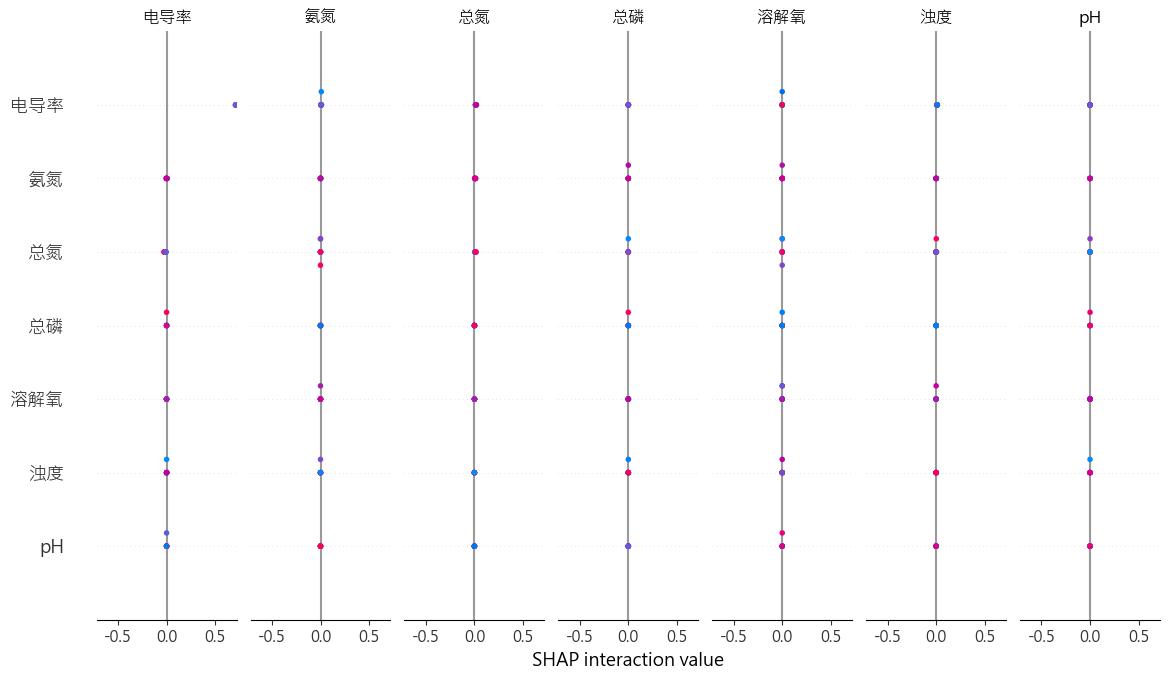

[34 35 36 37 38 77 78 79 80]


In [132]:
# 计算重构误差
MSE = np.mean(np.power(data_norm_test - reconstructed_data, 2), axis=1)
# 使用SHAP库计算SHAP值
background_set = shap.sample(data_norm,100) # 从数据中采样作为背景集

explainer = shap.KernelExplainer(autoencoder,background_set,n_jobs = -1)    # 创建解释器
# explainer = shap.KernelExplainer(autoencoder1,background_set,n_jobs = -1)    # 创建解释器
# explainer = shap.KernelExplainer(autoencoder2,background_set,n_jobs = -1)    # 创建解释器
# explainer = shap.KernelExplainer(vae,background_set,n_jobs = -1)    # 创建解释器
# explainer = shap.KernelExplainer(vae1,background_set,n_jobs = -1)    # 创建解释器
# explainer = shap.KernelExplainer(vae2,background_set,n_jobs = -1)    # 创建解释器

threshold = np.percentile(MSE, 97)  # 定义异常阈值
anomalies = np.where(MSE > threshold)[0]  # 找到异常数据的索引
need2explained = data_norm.iloc[[start_sclice + i for i in anomalies]]  # 获取异常数据
shap_values = explainer.shap_values(need2explained)
# 可视化SHAP值
shap.summary_plot(shap_values, need2explained)
nshap_values = np.array(shap_values)
# 结合SHAP值和重构误差来检测异常值
print(anomalies)

In [133]:
data.iloc[[start_sclice + i for i in anomalies]]


,水温,pH,溶解氧,高锰酸钾,氨氮,总磷,总氮,电导率,浊度
574,17.18,7.60,7.996,2.646,0.1470,0.0520,3.454,449.7,11.0
575,16.80,7.46,6.641,2.646,0.1908,0.0571,3.461,464.0,10.2
576,16.70,7.46,6.674,2.688,0.1894,0.0563,3.449,457.0,9.8
577,16.61,7.44,6.448,2.723,0.1973,0.0555,3.184,449.4,8.3
578,16.52,7.43,6.259,2.577,0.2008,0.0558,3.165,446.0,8.1
617,18.98,7.23,6.297,2.233,0.1911,0.0739,2.957,440.0,8.5
618,18.36,7.16,5.806,2.162,0.1984,0.0747,2.953,443.8,10.8
619,17.81,7.08,4.524,2.091,0.2321,0.0775,3.533,449.5,11.3
620,18.97,7.17,6.721,2.162,0.1597,0.0723,3.131,467.7,13.5


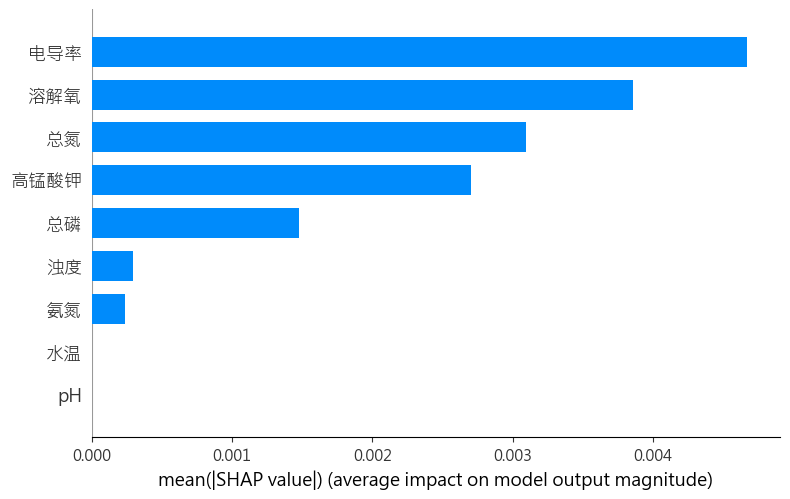

In [69]:
shap.summary_plot(nshap_values[:,0,:],need2explained,plot_type='bar')

In [70]:
# 将异常数据保存到Excel文件
ad_result =data.iloc[[start_sclice + i for i in anomalies]]
ad_result.to_excel('test1.xlsx',sheet_name='Sheet1',index=False)

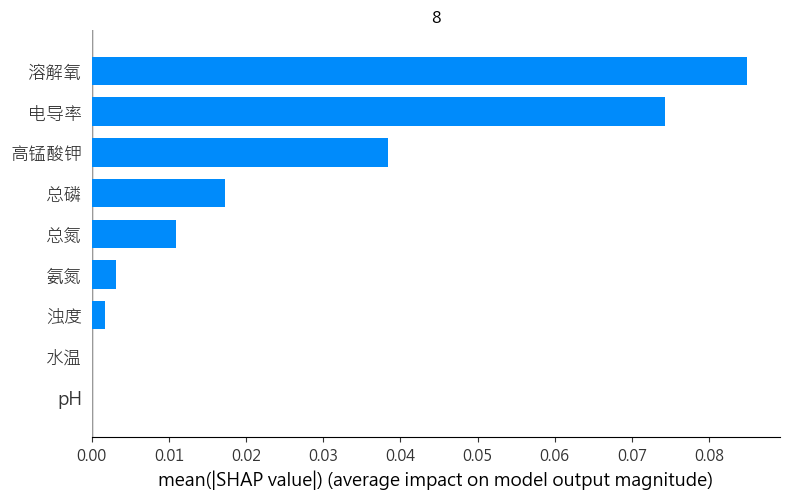

In [71]:
for i in range(8):
    plt.title(f"{i+1}")
    # shap.summary_plot(nshap_values[:,i,:],need2explained,plot_type='bar',show = False,title="SHAP_value",auto_size_plot=None)
    shap.summary_plot(nshap_values[:,i,:],need2explained,plot_type='bar',show = False,title="SHAP_value")
    plt.savefig(f'image_{i}.svg',bbox_inches='tight')

In [58]:
# images = []
# for i in range(8):
#     img = plt.imread(f"image_{i}.svg")
#     images.append(img)
# # 定义画布和子图
# fig, axs = plt.subplots(nrows=5,ncols=2,figsize=(1,2))
# plt.subplots_adjust(wspace=0.001,hspace=0.001)
# # 在子图中画出每张图片
# for i, ax in enumerate(axs.flat):
#     if i < len(images):
#         ax.imshow(images[i])
#         # ax.text(0.5, -0.1, f"{i+1}", transform=ax.transAxes,
#         #         fontsize=12, ha='center')
#     ax.axis('off')
# plt.tight_layout
# plt.savefig("most_8.svg",format="svg")
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.plot(history.history['loss'], 'b', label='训练曲线', linewidth=3)
# ax.plot(history.history['val_loss'], 'r', label='测试曲线', linewidth=3)
# # ax.set_title('Model loss', fontsize=16)
# ax.set_ylabel('损失率',fontsize=14)
# ax.set_xlabel('迭代次数'fontsize=14)
# ax.legend(loc='upper right',fontsize=12)
# plt.savefig(r'F:\loss.png')
# plt.show()
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3935044171.py, line 22)